In [1]:
%matplotlib inline

In [2]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.contrib import signal

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import os
import sys
import re

In [5]:
BITRATE = 16                      # Bit rate
SAMRATE = 16000                   # Sample rate (Hz)
SAMTIME = 1000.0 / SAMRATE        # Sample time (ms)
MAXAMPS = float(2**BITRATE / 2)   # Max samples amplitute

In [6]:
# Load noise matrix
NOISE_CLIP_DIR = '../data/noise_clips'
NOISE_MATRIX = np.loadtxt(os.path.join(NOISE_CLIP_DIR, 'noise_clips.csv'), delimiter=',')

In [7]:
# Tensorflow setup
sess = None
tf.logging.set_verbosity(tf.logging.INFO)

def reset_vars():
    """Initializes all tf variables"""
    sess.run(tf.global_variables_initializer())

def reset_tf():
    """Closes the current tf session and opens new session"""
    global sess
    if sess:
        sess.close()
    tf.reset_default_graph()
    sess = tf.Session()

## Create tensorflow preprocessing functions

Need functions for...

- Mel spectrogram (use `tf.contrib.signal library`)
- MFCCs (use `tf.contrib.signal library`)
- Zero crossing rate
- RMSE
- Window function

In [8]:
reset_tf()

In [9]:
# Test arrays
a = tf.placeholder(tf.float32, [16000,], name='a')
a2 = tf.placeholder(tf.float32, [5, 16000], name='a2')

b = 1.0 * np.arange(16000)
b2 = np.array([1.0 * np.arange(16000), 0.2 * np.arange(16000), 0.01 * np.arange(16000)])

c = np.array([1,2,4,-5,-6,-1,1,2,1,1,-1,1,4])
d = np.array([[1,2,3], [-4,5,6]])
d2 = np.array([[[1,2,3], [-4,5,6]],
               [[-1,2,3], [-4,5,6]],
               [[1,-2,3], [-4,5,6]],
               [[1,2,-3], [-4,5,6]]])
f = 0.8 * (np.random.rand(16000) - 0.5) + 0.5 * np.sin(0.2 * np.arange(16000)) + 0.5 * np.sin(0.05 * np.arange(16000))

In [10]:
def windower(arr, window=128, hop_length=32, rank=1):
    """Windower function that divides an array into fixed size windows"""
    overlap = window - hop_length
    length = arr.shape[rank - 1]
    indexer = tf.range(window)[None, :] + hop_length * tf.range((length - overlap) / hop_length)[:, None]
    return tf.gather(arr, indexer, axis=rank - 1)

In [11]:
windower(a)

<tf.Tensor 'Gather:0' shape=(497, 128) dtype=float32>

In [12]:
windower(a2, rank=2)

<tf.Tensor 'GatherV2:0' shape=(5, 497, 128) dtype=float32>

In [13]:
windower(b2, rank=2)

<tf.Tensor 'GatherV2_1:0' shape=(3, 497, 128) dtype=float64>

In [14]:
windower(b, rank=1)

<tf.Tensor 'Gather_1:0' shape=(497, 128) dtype=float64>

In [15]:
sess.run(windower(b2, rank=2)).shape

(3, 497, 128)

In [16]:
def tf_diff_axis(arr):
    """Equivalent of np.diff on last axis"""
    return arr[..., 1:] - arr[..., :-1]


def zero_crossing(arr, rank=1):
    """Calculates the zero crossing rate"""
    if rank == 1:
        nzc = tf.cast(tf.count_nonzero(tf_diff_axis(tf.sign(arr))), tf.float32)
    else:
        nzc = tf.cast(tf.count_nonzero(tf_diff_axis(tf.sign(arr)), axis=rank - 1), tf.float32)

    arrlen = tf.cast(arr.shape[rank - 1], tf.float32)
    return tf.divide(nzc, arrlen, name='zcr')

In [17]:
tf_diff_axis(d2)

array([[[ 1,  1],
        [ 9,  1]],

       [[ 3,  1],
        [ 9,  1]],

       [[-3,  5],
        [ 9,  1]],

       [[ 1, -5],
        [ 9,  1]]])

In [18]:
d

array([[ 1,  2,  3],
       [-4,  5,  6]])

In [19]:
tf_diff_axis(c)

array([ 1,  2, -9, -1,  5,  2,  1, -1,  0, -2,  2,  3])

In [20]:
sess.run(zero_crossing(d, rank=2))

array([0.        , 0.33333334], dtype=float32)

In [21]:
sess.run(zero_crossing(c, rank=1))

0.30769232

In [22]:
def rms_energy(arr, rank=1, maxamps=1.0):
    """Calculates the RMS energy of the wave"""
    if rank == 1:
        return tf.sqrt(tf.reduce_mean(tf.square(arr / maxamps)), name='rmse')
    else:
        return tf.sqrt(tf.reduce_mean(tf.square(arr / maxamps), axis=rank - 1), name='rmse')

In [23]:
# My windower function is faster
sess.run(signal.frame(b, 128, 32))

array([[0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 1.2500e+02, 1.2600e+02,
        1.2700e+02],
       [3.2000e+01, 3.3000e+01, 3.4000e+01, ..., 1.5700e+02, 1.5800e+02,
        1.5900e+02],
       [6.4000e+01, 6.5000e+01, 6.6000e+01, ..., 1.8900e+02, 1.9000e+02,
        1.9100e+02],
       ...,
       [1.5808e+04, 1.5809e+04, 1.5810e+04, ..., 1.5933e+04, 1.5934e+04,
        1.5935e+04],
       [1.5840e+04, 1.5841e+04, 1.5842e+04, ..., 1.5965e+04, 1.5966e+04,
        1.5967e+04],
       [1.5872e+04, 1.5873e+04, 1.5874e+04, ..., 1.5997e+04, 1.5998e+04,
        1.5999e+04]])

In [24]:
stfts = signal.stft(tf.cast(f, tf.float32), frame_length=256, frame_step=16, fft_length=128)

In [25]:
magnitude_spectrograms = tf.abs(stfts)

In [26]:
# Warp the linear-scale, magnitude spectrograms into the mel-scale
num_spectrogram_bins = magnitude_spectrograms.shape[-1].value
lower_edge_hertz = 80.0
upper_edge_hertz = 7600.0
num_mel_bins = 64

mel_weight_mat = signal.linear_to_mel_weight_matrix(num_mel_bins,
                                                    num_spectrogram_bins,
                                                    SAMRATE,
                                                    lower_edge_hertz,
                                                    upper_edge_hertz)

mel_spectrograms = tf.tensordot(magnitude_spectrograms, mel_weight_mat, 1)

# Note: Shape inference for tf.tensordot does not currently handle this case
mel_spectrograms.set_shape(magnitude_spectrograms.shape[:-1].concatenate(mel_weight_mat.shape[-1:]))

In [27]:
x1 = sess.run(mel_spectrograms)

In [28]:
# Matmul only works for single file, hence use of tensordot
x2 = sess.run(tf.matmul(magnitude_spectrograms, mel_weight_mat))

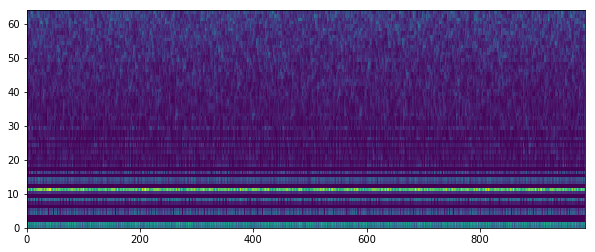

In [29]:
plt.figure(figsize=(10, 4))
plt.pcolormesh(x1.T);

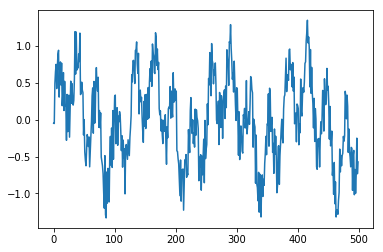

In [30]:
plt.plot(f[:500]);

## Function for full batch process

In [32]:
NOISE_MATRIX.shape

(120, 16000)

In [33]:
def signalProcessBatch(signals, add_noise=True, noise_factor=0.1, noise_frac=0.75, window=512,
                       maxamps=1.0, sr=16000, num_mel_bins=64, num_mfccs=19):
    """Function to perform all the DSP preprocessing and feature extraction.
       Returns the Mel spectrum, MFCCs, ZCR and RMSE.
       Works on a batch of num_files files.
       Input signals : [num_files, samples]
       Output        : [num_files, num_windows, num_mfccs]"""

    if add_noise:
        # Checks for both array input and tensor input
        num_files = tf.shape(signals)[0]
        #try:
        #    num_files = signals.shape[0].value
        #    if not num_files:
        #        num_files = -1
        #except AttributeError:
        #    num_files = signals.shape[0]

        idx = tf.random_uniform((num_files,), 0, NOISE_MATRIX.shape[0], dtype=tf.int32)
        noise = tf.cast(tf.gather(NOISE_MATRIX, idx), tf.float32)
        nf = tf.cast(tf.greater(tf.random_uniform([num_files, 1]), noise_frac), tf.float32)
        
        signals = signals + noise_factor * maxamps * noise * nf

    hop_length = window / 4
    signals32 = tf.cast(signals, tf.float32)
    signals_w = windower(signals32, window=window, hop_length=hop_length, rank=2)

    zcr = zero_crossing(signals_w, rank=3)
    rmse = rms_energy(signals_w, rank=3, maxamps=maxamps)

    stfts = signal.stft(signals32, frame_length=window, frame_step=hop_length, fft_length=window)
    magnitude_spectrograms = tf.abs(stfts)

    num_spectrogram_bins = magnitude_spectrograms.shape[-1].value
    lower_edge_hertz = 80.0
    upper_edge_hertz = 7600.0

    mel_weight_mat = signal.linear_to_mel_weight_matrix(num_mel_bins,
                                                        num_spectrogram_bins,
                                                        sr,
                                                        lower_edge_hertz,
                                                        upper_edge_hertz)

    mel_spectrograms = tf.tensordot(magnitude_spectrograms, mel_weight_mat, 1)
    mel_spectrograms.set_shape(magnitude_spectrograms.shape[:-1].concatenate(mel_weight_mat.shape[-1:]))

    log_offset = 1e-8
    log_mel_spectrograms = tf.log(mel_spectrograms + log_offset, name='log_mel_spectrograms')

    mfccs = signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_mfccs]
    mfccs = tf.identity(mfccs, name='mfccs')

    return mfccs, log_mel_spectrograms, zcr, rmse

In [34]:
a2.shape[0].value

5

In [35]:
signalProcessBatch(a2)

(<tf.Tensor 'mfccs:0' shape=(5, 122, 19) dtype=float32>,
 <tf.Tensor 'log_mel_spectrograms:0' shape=(5, 122, 64) dtype=float32>,
 <tf.Tensor 'zcr_2:0' shape=(5, 122) dtype=float32>,
 <tf.Tensor 'rmse:0' shape=(5, 122) dtype=float32>)

In [36]:
mfccs_vals, log_mel_vals, zcr_vals, rmse_vals = sess.run(signalProcessBatch(b2))

In [38]:
mfccs_vals.shape

(3, 122, 19)

## Testing

In [39]:
X_data = tf.placeholder(tf.float32, [None, SAMRATE], name='X_data')

In [40]:
X_data

<tf.Tensor 'X_data:0' shape=(?, 16000) dtype=float32>

In [42]:
test = signalProcessBatch(X_data)

In [44]:
X_data.shape

TensorShape([Dimension(None), Dimension(16000)])

In [45]:
sess.run(tf.greater(tf.random_uniform((5,1)), 0.75))

array([[False],
       [False],
       [ True],
       [ True],
       [ True]])

In [46]:
b2

array([[0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 1.5997e+04, 1.5998e+04,
        1.5999e+04],
       [0.0000e+00, 2.0000e-01, 4.0000e-01, ..., 3.1994e+03, 3.1996e+03,
        3.1998e+03],
       [0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.5997e+02, 1.5998e+02,
        1.5999e+02]])

In [ ]:
X_mfccs, X_log_mel_spectrograms, X_zcr, X_rmse = sess.run(signalProcessBatch(f))

In [ ]:
X_mfccs.shape

In [ ]:
plt.pcolormesh(X_mfccs[0].T)
plt.colorbar();

In [ ]:
X_mfccs_norm = sess.run(tf.nn.l2_normalize(X_mfccs, 1, epsilon=1e-8))

In [ ]:
plt.pcolormesh(X_mfccs_norm[0].T)
plt.colorbar();

In [ ]:
plt.plot(X_rmse[0]);

In [ ]:
plt.plot(X_mfccs_norm[0].T[2]);

In [ ]:
zcr_delta = tf_diff_axis(X_zcr)
rmse_delta = tf_diff_axis(X_rmse)

In [ ]:
X_rmse